In [0]:
# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


# Se importan las librerias a utilizar a lo largo de todo el código

In [0]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from plotnine import *


# Lectura de datos de los precios desde 1995 hasta 2018

In [7]:
!ls "./datos/precios/"

'Precio_Bolsa_Nacional_($kwh)_1995.xlsx'
'Precio_Bolsa_Nacional_($kwh)_1996.xlsx'
'Precio_Bolsa_Nacional_($kwh)_1997.xlsx'
'Precio_Bolsa_Nacional_($kwh)_1998.xlsx'
'Precio_Bolsa_Nacional_($kwh)_1999.xlsx'
'Precio_Bolsa_Nacional_($kwh)_2000.xlsx'
'Precio_Bolsa_Nacional_($kwh)_2001.xlsx'
'Precio_Bolsa_Nacional_($kwh)_2002.xlsx'
'Precio_Bolsa_Nacional_($kwh)_2003.xlsx'
'Precio_Bolsa_Nacional_($kwh)_2004.xlsx'
'Precio_Bolsa_Nacional_($kwh)_2005.xlsx'
'Precio_Bolsa_Nacional_($kwh)_2006.xlsx'
'Precio_Bolsa_Nacional_($kwh)_2007.xlsx'
'Precio_Bolsa_Nacional_($kwh)_2008.xlsx'
'Precio_Bolsa_Nacional_($kwh)_2009.xlsx'
'Precio_Bolsa_Nacional_($kwh)_2010.xlsx'
'Precio_Bolsa_Nacional_($kwh)_2011.xlsx'
'Precio_Bolsa_Nacional_($kwh)_2012.xlsx'
'Precio_Bolsa_Nacional_($kwh)_2013.xlsx'
'Precio_Bolsa_Nacional_($kwh)_2014.xlsx'
'Precio_Bolsa_Nacional_($kwh)_2015.xlsx'
'Precio_Bolsa_Nacional_($kwh)_2016.xls'
'Precio_Bolsa_Nacional_($kwh)_2017.xls'
'Precio_Bolsa_Nacional_($kwh)_2018.xls'


Lo que queremos al final, es trabajar con precios diarios, pero tenemos varios precios al día, así que para convertirlos a una sola medición obtendremos la media de cada día que es la que al final usaremos

In [0]:
nombres = ['Fecha','media', 'AM']

In [0]:
datos = pd.DataFrame(columns= nombres)
for f in sorted(glob.glob("./datos/precios/*")):
    df = pd.read_excel(f)
    # Esto debido a que no todos los archivos tienen la misma cantidad de columnas
    df  = df.iloc[:,0:25]
    df = df.dropna()       
    df.rename(columns=df.iloc[0], inplace = True)
    df = df.drop(df.index[0])
    df.reset_index(drop=True, inplace=True)
    # Aquí calculamos el promedio de cada fila de la base de datos
    df['media'] = df.mean(axis=1)
    # Aquí agregamos únicamente la fecha y la media que es lo que necesitamos ignorando las diferentes mediciones diarias
    df = df.iloc[:,lambda df: [0, 25]]
    df['Fecha'] = df['Fecha'].astype(str) 
    df['AM'] = df['Fecha'].apply(lambda m: m[:4] + m[5:7])
    df.columns = nombres
    datos = pd.concat([datos, df])

In [10]:
# Como podemos apreciar a continuación terminamos teniendo un solo archivo de 8381 filas y 2 columnas
datos.head

<bound method NDFrame.head of           Fecha      media      AM
0    1995-07-21   4.924333  199507
1    1995-07-22   1.269500  199507
2    1995-07-23   0.953083  199507
3    1995-07-24   4.305917  199507
4    1995-07-25   1.149167  199507
..          ...        ...     ...
120  2018-05-01  71.990096  201805
121  2018-05-02  76.941468  201805
122  2018-05-03  71.471718  201805
123  2018-05-04  64.847801  201805
124  2018-05-05  73.982048  201805

[8381 rows x 3 columns]>

# Reconversión de precios medios diarios
Ahora debemos de llevar el precio a moneda constante, para eso utilizamos la inflación total al consumidor

In [12]:
# Lectura de la base de datos

variaciones = pd.read_excel("./1.2.5.IPC_Serie_variaciones.xlsx", header=12)

# Obtenemos la fecha, el indice y la inflación anual de toda la base de datos
variaciones = variaciones.iloc[:-6, lambda variaciones: [0,1]]
variaciones = variaciones.rename(columns={'Año(aaaa)-Mes(mm)': 'AM', 'Índice':'INDICE'})
variaciones['AM'] = variaciones['AM'].astype(str)
                               
variaciones.head()


,AM,INDICE
0,195407,0.03
1,195408,0.03
2,195409,0.03
3,195410,0.03
4,195411,0.03


In [0]:
datos = pd.merge(datos, variaciones, on="AM")
datos = datos.iloc[:,[0,1,3]]

In [14]:
datos.head

<bound method NDFrame.head of            Fecha      media  INDICE
0     1995-07-21   4.924333   20.93
1     1995-07-22   1.269500   20.93
2     1995-07-23   0.953083   20.93
3     1995-07-24   4.305917   20.93
4     1995-07-25   1.149167   20.93
...          ...        ...     ...
8376  2018-05-01  71.990096   99.16
8377  2018-05-02  76.941468   99.16
8378  2018-05-03  71.471718   99.16
8379  2018-05-04  64.847801   99.16
8380  2018-05-05  73.982048   99.16

[8381 rows x 3 columns]>

Ya tenemos la media y el índice asociado, por lo que debemos de aplilcar la formula para poder deflactar, teniendo como ICP final, el último de la base de datos actualizada, y el inicial el de cada uno de los días

In [15]:
ICP_final = datos.tail(1).iloc[0,2]
ICP_final

99.16

In [16]:
datos['media_actualizada'] = datos["media"]*(ICP_final/datos["INDICE"])
datos.head

<bound method NDFrame.head of            Fecha      media  INDICE  media_actualizada
0     1995-07-21   4.924333   20.93          23.330000
1     1995-07-22   1.269500   20.93           6.014506
2     1995-07-23   0.953083   20.93           4.515420
3     1995-07-24   4.305917   20.93          20.400129
4     1995-07-25   1.149167   20.93           5.444404
...          ...        ...     ...                ...
8376  2018-05-01  71.990096   99.16          71.990096
8377  2018-05-02  76.941468   99.16          76.941468
8378  2018-05-03  71.471718   99.16          71.471718
8379  2018-05-04  64.847801   99.16          64.847801
8380  2018-05-05  73.982048   99.16          73.982048

[8381 rows x 4 columns]>

In [0]:
datos['Fecha'] =  pd.to_datetime(datos['Fecha'])

In [18]:
datos = datos.iloc[:,[0,1,3]]
datos.head(10)

,Fecha,media,media_actualizada
0,1995-07-21,4.924333,23.330000
1,1995-07-22,1.269500,6.014506
2,1995-07-23,0.953083,4.515420
3,1995-07-24,4.305917,20.400129
4,1995-07-25,1.149167,5.444404
5,1995-07-26,1.108625,5.252329
6,1995-07-27,0.585958,2.776093
7,1995-07-28,0.499792,2.367862
8,1995-07-29,0.927667,4.395004
9,1995-07-30,0.669458,3.171691


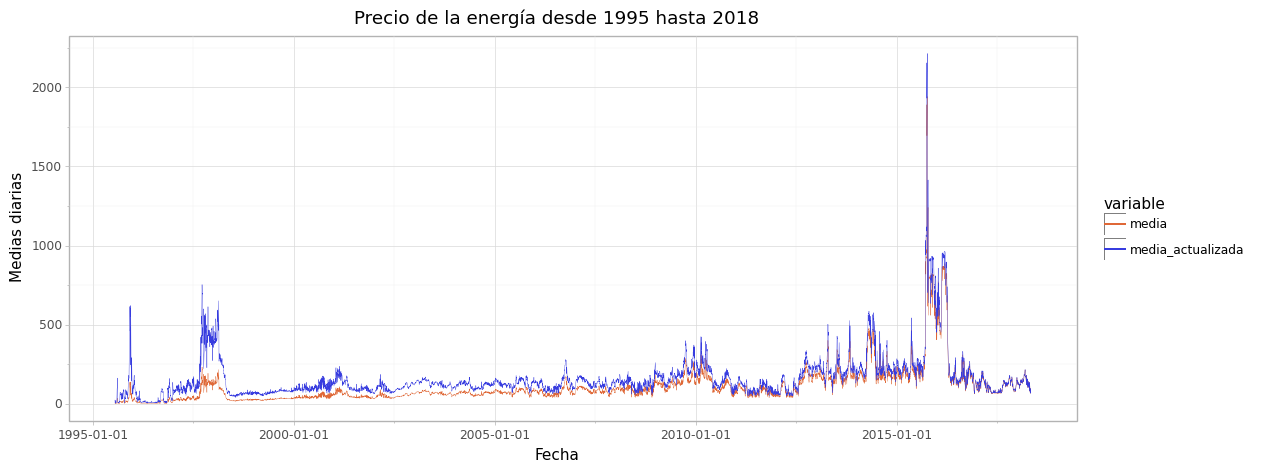

<ggplot: (8740795702199)>

In [19]:
ggplot(pd.melt(datos, id_vars='Fecha'), aes(x='Fecha', y='value', color='variable')) +\
theme_light() +\
theme(figure_size=(13,5)) +\
geom_line(size=0.15) +\
ggtitle('Precio de la energía desde 1995 hasta 2018') +\
ylab('Medias diarias') +\
scale_color_manual(values=('#DF6837','#373CDF'))

# Selección de transformaciones

In [0]:
Fechas = datos.iloc[:,[0]]
precios = datos.iloc[:,[2]]

In [0]:
datos2 = datos.iloc[:,[0,2]]

In [22]:
# Raiz cuadrada
datos2.insert(2,"raiz_cuadrada", np.sqrt(datos2['media_actualizada']), True)
# Raiz cúbica
datos2.insert(2, "raiz_cubica", np.cbrt(datos2['media_actualizada']), True)
# Raiz cuarta
datos2.insert(2, "raiz_cuarta", np.power(datos2['media_actualizada'], (1/4)), True)
# Raiz quinta
datos2.insert(2, "raiz_quinta", np.power(datos2['media_actualizada'], (1/5)), True)
# Logaritmo natural
datos2.insert(2, "logaritmo_natural", np.log(datos2['media_actualizada']), True)

datos2.head()

,Fecha,media_actualizada,logaritmo_natural,raiz_quinta,raiz_cuarta,raiz_cubica,raiz_cuadrada
0,1995-07-21,23.330000,3.149740,1.877513,2.197752,2.857404,4.830114
1,1995-07-22,6.014506,1.794174,1.431660,1.566030,1.818584,2.452449
2,1995-07-23,4.515420,1.507498,1.351885,1.457721,1.652847,2.124952
3,1995-07-24,20.400129,3.015541,1.827791,2.125241,2.732400,4.516650
4,1995-07-25,5.444404,1.694588,1.403428,1.527522,1.759206,2.333325


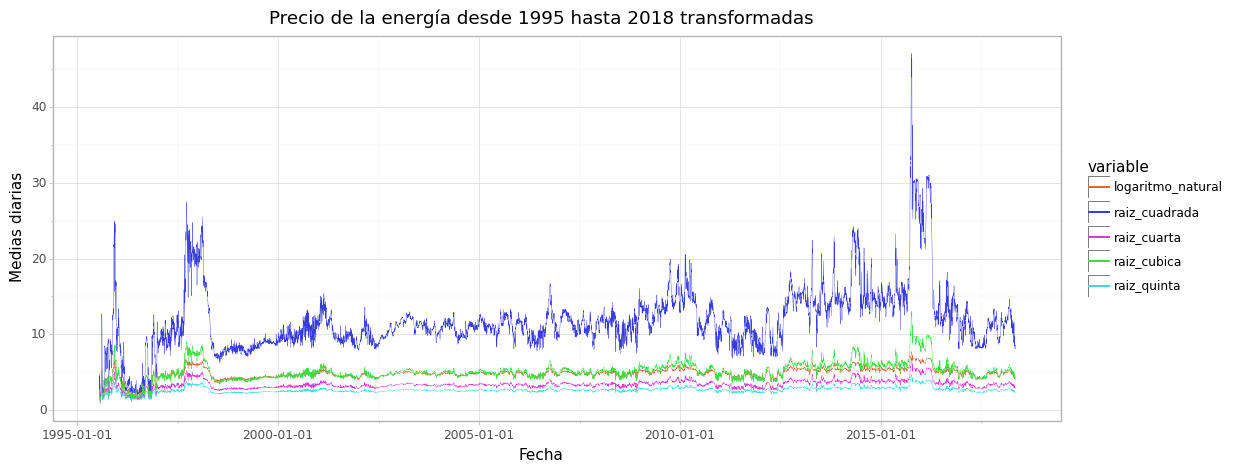

<ggplot: (-9223363296059242706)>

In [23]:
ggplot(pd.melt(datos2.iloc[:,[0,2,3,4,5,6]], id_vars='Fecha'), aes(x='Fecha', y='value', color='variable')) +\
theme_light() +\
theme(figure_size=(13,5)) +\
geom_line(size=0.15) +\
ggtitle('Precio de la energía desde 1995 hasta 2018 transformadas') +\
ylab('Medias diarias') +\
scale_color_manual(values=('#DF6837','#373CDF', '#DF37DC', '#37DF41', '#37DFDC'))

# Modelo adaline optimizado con gradiente y momentun

In [0]:
class Adaline:
    def __init__(self,
                 learning_rate=0.001,
                 momentum=0,                         
                 max_epochs=100,      
                 shuffle=False,       
                 random_state=None,   
                 warm_start=False):   
        
        self.momentum = momentum
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.shuffle = shuffle
        self.random_state = random_state
        self.warm_start = warm_start
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):

        if not isinstance(X, np.ndarray):
            X = np.array(X)
        if not isinstance(y, np.ndarray):
            d = np.array(y)
        else:
            d = y.copy()

        if self.random_state is not None:
            np.random.RandomState(self.random_state)

        if self.coef_ is None or self.warm_start is False:
            self.coef_ = np.random.uniform(0, 1, X.shape[1])

        if self.intercept_ is None  or self.warm_start is False:
            self.intercept_ = np.random.uniform(0, 1, 1)

        errors2 = []
        forecasts = []

        for epoch in range(self.max_epochs):

            if self.shuffle is True:
                n = list(range(X.shape[0]))
                np.random.shuffle(n)
                X = X[n,:] 
                d = d[n]

            for i in range(X.shape[0]):
                u = np.dot(X[i,:], self.coef_) + self.intercept_ 
                e = (d[i] - u)[0]
                self.coef_ += 2 * self.learning_rate * e * X[i,:] + self.coef_ * self.momentum
                self.intercept_ += 2 * self.learning_rate * e
                errors2.append(e**2)
                forecasts.append(u)

        return errors2, forecasts

    def predict(self, X):
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        u = np.dot(X, self.coef_) + self.intercept_
        return u

# Seleccionamos las transformaciones a usar y la función que corre los modelos con las diferentes transformaciones

In [0]:
transformaciones = ['ninguna', 'log', 'raiz_cuadrada','raiz_cubica','raiz_cuarta','raiz_quinta']

In [0]:
error_optimo = None
transformacion_optmima = None
L_optimo = None
tasa_aprendizaje_optima = None
momentum_optimo =  None
pred = []
f = None
err = None

In [28]:
train, test = train_test_split(precios, test_size=7, shuffle = False)
train2 = np.array(train['media_actualizada']).reshape(-1,1)
test2 = np.array(test['media_actualizada']).reshape(-1,1)
test2

array([[70.79883463],
       [96.10564172],
       [71.99009557],
       [76.94146817],
       [71.47171757],
       [64.84780083],
       [73.98204843]])

In [0]:
for transformacion in transformaciones:
  for L in range(5,15):
    for tasa in np.arange(0.01,0.1, 0.01):
      for momentum in np.arange(0.00000,0.0001,0.00001):
        precios2 = train2.copy()
        if (transformacion == 'log'):
          precios2 = np.log(precios2)
        elif (transformacion == 'raiz_cuadrada'):
          precios2 = np.sqrt(precios2)
        elif (transformacion == 'raiz_cubica'):
          precios2 = np.cbrt(precios2)
        elif (transformacion == 'raiz_cuarta'):
          precios2 = np.power(precios2, (1/4))
        elif (transformacion == 'raiz_quinta'):
          precios2 = np.power(precios2, (1/5))

        scaler = MinMaxScaler()
        datos_escalados = scaler.fit_transform(precios2)
        datos_escalados = [u[0] for u in datos_escalados]


        adaline = Adaline(
          learning_rate=tasa,
          momentum = momentum,
          max_epochs=1, 
          shuffle=False,
          random_state=423,
          warm_start=False)
        
        X = []
        for t in range(L, len(datos_escalados)):
          X.append(datos_escalados[t-L:t].copy())

        errors2, forecasts = adaline.fit(
          X,
          datos_escalados[L:])
        
        pronosticos = []

        for i in range(7):
          dia_siguiente = adaline.predict(X[-1])
          siguiente_X = np.append(X[-1][1:L], [dia_siguiente])
          X = np.concatenate((X, [siguiente_X] ), axis=0)
          pronosticos.append(dia_siguiente[0])

        pronosticos = scaler.inverse_transform([[u] for u in pronosticos])
        pronosticos = [u[0] for u in pronosticos]

        if (transformacion == 'log'):
          pronosticos = np.exp(pronosticos)
        elif (transformacion == 'raiz_cuadrada'):
          pronosticos = np.power(pronosticos, 2)
        elif (transformacion == 'raiz_cubica'):
          pronosticos = np.power(pronosticos, 3)
        elif (transformacion == 'raiz_cuarta'):
          pronosticos = np.power(pronosticos, 4)
        elif (transformacion == 'raiz_quinta'):
          pronosticos = np.power(pronosticos, 5)

        mse = mean_squared_error(test2,pronosticos)
        if (error_optimo is None or error_optimo > mse):
          error_optimo = mse
          transformacion_optmima = transformacion
          L_optimo = L
          tasa_aprendizaje_optima = tasa
          momentum_optimo = momentum
          pred = pronosticos.copy()
          f = forecasts.copy()
          err = errors2.copy()

Los resultados obtenidos fueron los siguientes:

In [67]:
print("Error cuadrático medio óptimo: ", error_optimo)
print("Transformación óptima: ", transformacion_optmima)
print("L óptimo: ", L_optimo)
print("Tasa aprendizaje óptima: ", tasa_aprendizaje_optima)
print("Momentum óptimo: ", momentum_optimo)

Error cuadrático medio óptimo:  60.47782673129982
Transformación óptima:  raiz_quinta
L óptimo:  11
Tasa aprendizaje óptima:  0.01
Momentum óptimo:  1e-05


In [0]:
A continuación podemos observar una gráfica con el forecasts y los valores reales

In [0]:
precios2 = train2.copy()
precios2 = np.power(precios2, (1/5))

scaler = MinMaxScaler()
datos_escalados = scaler.fit_transform(precios2)
datos_escalados = [u[0] for u in datos_escalados]

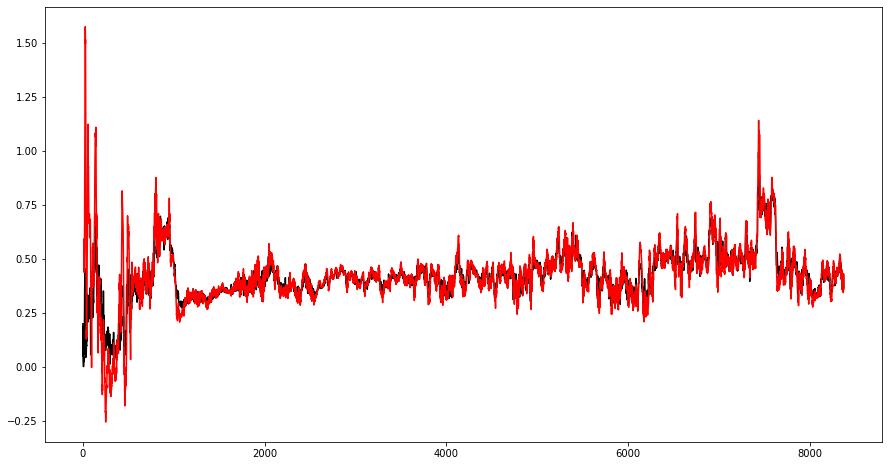

In [111]:
plt.figure(figsize=(15,8))
plt.plot(datos_escalados, color='black');
plt.plot(range(11,len(datos_escalados)), f, color = 'red');

Gŕafica de los errores obtenidos

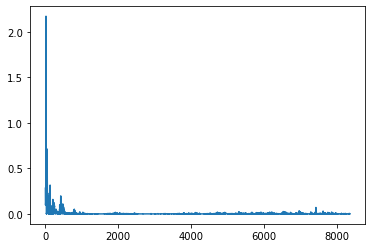

In [112]:
plt.plot(err)

Como se pueden apreciar en ambas gráficas, el error se concentró al principio de la serie, debido a que todavía no se tenían suficientes observaciones para entender el comportamiento de la serie.

# Predicción de los 7 días

In [0]:
fechas = Fechas.iloc[8374:,:]
fechas.reset_index(drop=True, inplace=True)
fechas.insert(1,"Predichos",pred,True)
fechas.insert(2,"Reales",test2,True)

In [127]:
fechas

,Fecha,Predichos,Reales
0,2018-04-29,85.359743,70.798835
1,2018-04-30,84.174123,96.105642
2,2018-05-01,73.576014,71.990096
3,2018-05-02,70.412539,76.941468
4,2018-05-03,67.515767,71.471718
5,2018-05-04,62.065508,64.847801
6,2018-05-05,73.325671,73.982048


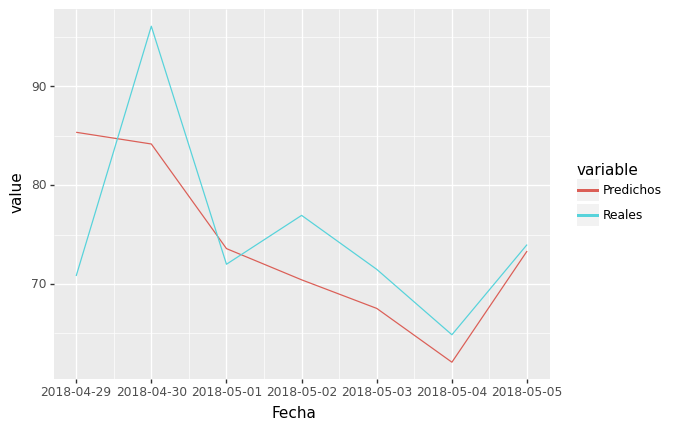

<ggplot: (-9223363296062855038)>

In [130]:
ggplot(pd.melt(fechas, id_vars='Fecha'), aes(x='Fecha', y='value', color='variable')) +\
geom_line()

# Conclusión

Podemos apreciar que el mejor modelo obtenido obtuvo las siguientes características:

- Error cuadrático medio:  60.47782673129982
- Transformación:  Raiz quinta
- L óptimo:  11
- Tasa aprendizaje óptima:  0.01
- Momentum óptimo:  1e-05